In [ ]:
import sys
sys.path.append('../../')
import time
from jax_smi import initialise_tracking
initialise_tracking()
from tqdm import tqdm

In [2]:
from dataclasses import dataclass, field, asdict
from typing import Tuple, Optional, Union
from EasyLM.models.gpt2.gpt2_model import GPT, GPTConfig, get_pretrained_params
from torch.utils.data import DataLoader

@dataclass(frozen=True)
class WandbConfig:
    """
    wandb logging configuration
    """
    entity: str = 'ars22'
    """username or team name where you're sending runs"""
    project: str = 'star_graph'
    """project name"""
    name: str = 'gpt2'
    """experiment name"""
    mode: str = 'online'
    """'offline', 'online', or 'disabled'"""
    notes: str = ''


@dataclass(frozen=True)
class CosineDecayScheduleConfig:
    init_value: float = 0.0
    peak_value: float = 2.5e-4
    warmup_steps: int = 2000
    decay_steps: int = 150000
    end_value: float = 1e-5

@dataclass(frozen=True)
class StaticLRConfig:
    init_value: float = 1e-5

@dataclass(frozen=False)
class TrainConfig:
    gpt2_model_type: str = 'gpt2' # gpt2 model type
    seed: int = 555
    out_dir: str = 'out'                        # output directory for checkpoints (can be gcs path)
    shuffle_buffer_size: int = 128
    eval_interval: int = 500
    eval_steps: int = 16        # evaluate for this number of steps (per-device)
    eval_only: bool = False     # if True, script exits right after the first eval
    keep_checkpoints: int = 3   # number of historical checkpoints to keep
    batch_size: int = 128        # per-device batch size
    train_steps: int = 30     # total number of training iterations
    weight_decay: float = 0.  # not applied to bias and embedding parameters
    grad_clip: float = 1.0      # gradient norm clipping magnitude
    gradient_accumulation_steps: int = 1    # used to simulate larger batch sizes
    betas: Tuple[float, float] = (0.9, 0.95) # adamw optimizer betas
    # learning_rate: CosineDecayScheduleConfig = field(default_factory=CosineDecayScheduleConfig)
    learning_rate: StaticLRConfig = field(default_factory=StaticLRConfig)
    wandb: WandbConfig = field(default_factory=WandbConfig) # wandb logging
    model: GPTConfig = field(default_factory=GPTConfig)     # gpt model config
    remat: bool = False    # set to True to rematerialize gradients during backward pass


def get_default_config() -> TrainConfig:
    return TrainConfig()

config = get_default_config()
config

/home/asetlur/anaconda3/envs/easylm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Exception in thread Thread-4 (inner):
Traceback (most recent call last):
  File "/home/asetlur/anaconda3/envs/easylm/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 593, in backends
    backend = _init_backend(platform)
  File "/home/asetlur/anaconda3/envs/easylm/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 647, in _init_backend
    backend = registration.factory()
  File "/home/asetlur/anaconda3/envs/easylm/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 200, in tpu_client_timer_callback
    client = xla_client.make_tpu_client()
  File "/home/asetlur/anaconda3/envs/easylm/lib/python3.10/site-packages/jaxlib/xla_client.py", line 169, in make_tpu_client
    return make_tfrt_tpu_c_api_client()
  File "/home/asetlur/anaconda3/envs/easylm/lib/python3.10/site-packages/jaxlib/xla_client.py", line 107, in make_tfrt_tpu_c_api_client
    return _xla.get_c_api_client('tpu', options)
jaxlib.xla_extension.XlaRuntimeError: UNKNOWN: TPU initialization failed: open

TrainConfig(gpt2_model_type='gpt2', seed=555, out_dir='out', shuffle_buffer_size=128, eval_interval=500, eval_steps=16, eval_only=False, keep_checkpoints=3, batch_size=128, train_steps=30, weight_decay=0.0, grad_clip=1.0, gradient_accumulation_steps=1, betas=(0.9, 0.95), learning_rate=StaticLRConfig(init_value=1e-05), wandb=WandbConfig(entity='ars22', project='star_graph', name='gpt2', mode='online', notes=''), model=GPTConfig(block_size=1024, vocab_size=50257, num_layers=12, num_heads=12, num_embeds=768, dropout_rate=0.1, use_bias=True, dtype=None), remat=False)

In [3]:
import jax
import jax.numpy as jnp
import flax
from flax.core import FrozenDict, frozen_dict
from flax.training import checkpoints
from flax.training.train_state import TrainState
from flax.jax_utils import replicate, unreplicate
import optax
from functools import partial

2024-05-15 19:57:21.397359: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2024-05-15 19:57:21.397444: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2024-05-15 19:57:21.397450: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
from torch.utils.data import Dataset
import torch

def prefix_target_list(filename=None):
    """
    Load graphs and split them into prefix and target and return the list
    """
    data_list = []
    with open(filename, 'r') as f:
        lines = f.readlines()
    for line in lines:
        prefix = line.strip().split('=')[0] + '='
        target = line.strip().split('=')[1]
        # target = target.split(',')[1]
        data_list.append((prefix, target))
    return data_list


class Graphs(Dataset):
    def __init__(self, tokenizer, n_samples, data_path):
        self.tokenizer = tokenizer
        self.n_samples = n_samples
        self.data_path = data_path
        self.eval_mode = False
        self.data_file = prefix_target_list(self.data_path)
        self.tokenized, self.num_prefix_tokens, self.num_target_tokens = self.tokenize(self.data_file[:n_samples])

    def __len__(self):
        return len(self.tokenized)

    def __getitem__(self, idx):
        if self.eval_mode:
            # In eval mode return the entire sequence
            return self.tokenized[idx].to(self.device)

        # Create inputs
        x = self.tokenized[idx].clone()
        y = torch.cat([-torch.ones((self.num_prefix_tokens - 1, )),
                       x[self.num_prefix_tokens:].clone()])
        return x[:-1], y.long()

    def tokenize(self, data_list):
        """
        Takes a list of prefix-target pairs, tokenizes and concatenates them
        """
        out = []
        prefix_len = len(self.tokenizer.encode(data_list[0][0]))
        target_len = len(self.tokenizer.encode(data_list[0][1]))
        same_len = True

        for prefix, target in data_list:
            prefix = torch.tensor(self.tokenizer.encode(prefix))
            target = torch.tensor(self.tokenizer.encode(target))
            if not (len(prefix) == prefix_len and len(target) == target_len):
                same_len = False
            seq = torch.concatenate([prefix, target], dim=-1).long()
            out.append(seq)

        # Check if all prefixes and all targets have the same length
        if not same_len:
            print('Not all prefixes or targets have the same length!!')
        else:
            print('Equal sequence lengths!')

        return out, prefix_len, target_len

    def eval(self):
        # Switch to "eval" mode when generating sequences without teacher-forcing
        self.eval_mode = True

    def train(self):
        # Switch back to "train" mode for teacher-forcing
        self.eval_mode = False

In [5]:
# LOAD TOKENIZER
from transformers import AutoTokenizer # type: ignore
tokenizer = AutoTokenizer.from_pretrained(config.gpt2_model_type)
tokenizer.pad_token_id = tokenizer.eos_token_id

# LOAD DATASET
data_path = 'deg_2_path_4_nodes_20'
train_path, test_path = data_path + '_train_200000.txt', data_path + '_test_20000.txt'
train_data = Graphs(tokenizer=tokenizer, n_samples=30000, data_path=train_path)
test_data = Graphs(tokenizer=tokenizer, n_samples=200, data_path=test_path)
train_data.train()

# sanity check
print(train_data[0], tokenizer.decode(train_data[0][0]), tokenizer.decode(train_data[0][1][-train_data.num_target_tokens:]))

# LOAD DATALOADER
train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True, drop_last=True) 
test_loader = DataLoader(test_data, batch_size=config.batch_size, shuffle=False, drop_last=False)


Equal sequence lengths!
Equal sequence lengths!
(tensor([  23,   11,   18,   91,   18,   11,  940,   91, 1415,   11, 1485,   91,
         940,   11,   16,   91, 1558,   11, 1415,   91,   23,   11, 1558,   14,
          23,   11, 1485,   28,   23,   11, 1558,   11, 1415,   11]), tensor([  -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
          -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
          -1,   -1,   -1,   23,   11, 1558,   11, 1415,   11, 1485])) 8,3|3,10|14,13|10,1|17,14|8,17/8,13=8,17,14, 8,17,14,13


In [6]:
print("tokenizer vocab size: ", tokenizer.vocab_size, train_data.num_prefix_tokens, train_data.num_target_tokens)

tokenizer vocab size:  50257 28 7


In [7]:
def param_decay_mask(params: FrozenDict) -> FrozenDict:
    """ pytree mask for non-bias parameters """
    flat_params = flax.traverse_util.flatten_dict(params)
    flat_param_mask = {k: k[-1] not in ('bias', 'embedding', 'scale') for k in flat_params.keys()}
    param_mask = flax.traverse_util.unflatten_dict(flat_param_mask)
    return frozen_dict.freeze(param_mask)

def init_train_state(key, config: TrainConfig, learning_rate) -> TrainState:

    if config.remat:
        model = flax.linen.remat(GPT,
            static_argnums=(2,),
            policy=jax.checkpoint_policies.checkpoint_dots_with_no_batch_dims)(config.model)
    else:
        config.model, params = get_pretrained_params(config.gpt2_model_type)
        model = GPT(config.model)    
        model.init(key)

    optimizer = optax.chain(
        # Apply weight decay only to non-bias parameters
        optax.clip_by_global_norm(config.grad_clip),
        optax.adamw(learning_rate, *config.betas, weight_decay=config.weight_decay, mask=param_decay_mask(params)),
        optax.apply_every(config.gradient_accumulation_steps),
    )

    train_state = TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer)

    return train_state

def count_params(params: FrozenDict) -> int:
    p = jax.tree_util.tree_map(lambda a: a.size if isinstance(a, jnp.ndarray) else 0, params)
    return jax.tree_util.tree_reduce(lambda a, b: a + b, p)

In [8]:
# =====  init parameters ============
key = jax.random.PRNGKey(config.seed)
key, key_params, key_dropout, key_generation = jax.random.split(key, 4)
# make sure dropout keys are different for each device (local and global)
key_dropout = jax.random.fold_in(key_dropout, jax.process_index())
keys_dropout = jax.random.split(key_dropout, jax.local_device_count())
key_gen = jax.random.split(key_generation, jax.local_device_count())

In [9]:
learning_rate = config.learning_rate.init_value
train_state = init_train_state(key_params, config, learning_rate)
num_params = count_params(train_state.params)

loading weights from pretrained gpt: gpt2


In [10]:
print(f"Total parameters: {num_params:,}") # 774,030,080 for gpt2-large

Total parameters: 124,439,808


In [11]:
from flax.core import FrozenDict, freeze, unfreeze
from transformers import FlaxGPT2LMHeadModel
hf_model = FlaxGPT2LMHeadModel.from_pretrained(config.gpt2_model_type)
hf_params = hf_model.init_weights(key_params, (2, config.model.block_size))

In [12]:
# replicate model
train_state = replicate(train_state)
hf_params = replicate(hf_params)


In [13]:
def cross_entropy_loss_and_accuracy(logits, tokens, valid=None):
    if valid is None:
        valid = jnp.ones(tokens.shape[:2])
    valid = valid.astype(jnp.float32)
    valid_text_length = jnp.maximum(jnp.sum(valid, axis=-1), 1e-10)
    logits = logits.astype(jnp.float32)  # for numerical stability
    token_log_prob = jnp.squeeze(
        jnp.take_along_axis(
            jax.nn.log_softmax(logits, axis=-1),
            jnp.expand_dims(tokens, -1),
            axis=-1,
        ),
        -1,
    )
    token_log_prob = jnp.where(valid > 0.0, token_log_prob, jnp.array(0.0))
    loss = -(jnp.sum(token_log_prob) / jnp.sum(valid))
    # old: loss = -jnp.mean(jnp.sum(token_log_prob, axis=-1) / valid_text_length)
    # changed to match hf implementation
    correct = jnp.where(
        valid > 0.0,
        jnp.argmax(logits, axis=-1) == tokens,
        jnp.array(False)
    )
    accuracy = jnp.mean(jnp.sum(correct, axis=-1) / valid_text_length)
    return loss, accuracy


@partial(jax.pmap, axis_name='batch', in_axes=(0, 0, 0, 0))
def train_step(state: TrainState, input_tokens: jnp.ndarray, target_tokens: jnp.ndarray, dropout_key):
    dropout_key = jax.random.fold_in(dropout_key, state.step)
    def loss_fn(params: FrozenDict) -> jnp.ndarray:
        logits = state.apply_fn(params, input_tokens, False, rngs={'dropout': dropout_key})
        
        logits = logits.astype(jnp.float32)  # for numerical stability
        token_log_prob = jnp.squeeze(
            jnp.take_along_axis(
                jax.nn.log_softmax(logits, axis=-1),
                jnp.expand_dims(target_tokens, -1),
                axis=-1,
            ),
            -1,
        )
        prob_hard_token = jnp.exp(token_log_prob[:, train_data.num_prefix_tokens+1]).mean()
        
        loss, acc = cross_entropy_loss_and_accuracy(
            logits, target_tokens, (target_tokens > 0).astype(jnp.int32))
        
        return loss, (prob_hard_token, acc)
    # per-device loss and grads
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (prob_hard_token, acc)), grads = grad_fn(state.params)
    # average gradients across devices
    prob_hard_token = jax.lax.pmean(prob_hard_token, axis_name="batch")
    grads = jax.lax.pmean(grads, axis_name="batch")
    loss = jax.lax.pmean(loss, axis_name="batch")
    acc = jax.lax.pmean(acc, axis_name="batch")
    new_state = state.apply_gradients(grads=grads)
    
    return loss, acc, prob_hard_token, new_state


from flax.traverse_util import flatten_dict, unflatten_dict

def convert_jax_params_to_hf(hf_params, jax_params) -> FrozenDict:
    hf_params = unfreeze(hf_params)
    
    for k in ['ln_f', 'wpe', 'wte']:
        hf_params['transformer'][k] = jax_params[k]
    for k in hf_params['transformer']['h'].keys():
        hf_params['transformer']['h'][k] = jax_params[k] 

    hf_params = flatten_dict(hf_params, sep='.')
    for k in hf_params.keys():
        if k.endswith('attn.c_attn.kernel'):
            hf_params[k] = hf_params[k].T
        elif k.endswith('attn.c_proj.kernel'):
            hf_params[k] = hf_params[k].T
        elif len(k.split('.')) > 3 and k.split('.')[3] == 'mlp' and k.endswith('kernel'):
            hf_params[k] = hf_params[k].T
    hf_params = unflatten_dict({k: v for k, v in hf_params.items()}, sep='.')
    return freeze(hf_params)


@partial(jax.pmap, axis_name='batch', in_axes=(0, 0, 0, 0))
def eval_step(hf_params, state, input_tokens: jnp.ndarray, target_tokens: jnp.ndarray):
    hf_params = convert_jax_params_to_hf(hf_params, state.params['params'])
    output = hf_model.generate(
        input_tokens[:, :train_data.num_prefix_tokens],
        params=hf_params,
        max_new_tokens=train_data.num_target_tokens,
        min_length=train_data.num_target_tokens+train_data.num_prefix_tokens, 
        do_sample=False, 
        attention_mask=jnp.ones_like(input_tokens[:, :train_data.num_prefix_tokens]))
    acc = ((output[0][:, -train_data.num_target_tokens:] == target_tokens[:, -train_data.num_target_tokens:]).sum(1) == train_data.num_target_tokens).mean()
    acc = jax.lax.pmean(acc, axis_name="batch")
    return acc

max_new_tokens = train_data.num_target_tokens
num_beams=2
num_return_sequences=2
temperature=1.0

from flax.core import FrozenDict, freeze, unfreeze

@partial(jax.pmap, axis_name='batch', in_axes=(0, 0, 0, 0))
def generate_negative_data(hf_params, train_state, input_tokens, key):
    hf_params = convert_jax_params_to_hf(hf_params, train_state.params['params'])
    return hf_model.generate(
        input_tokens[:, :train_data.num_prefix_tokens],
        params=hf_params,
        max_new_tokens=max_new_tokens, 
        min_length=train_data.num_target_tokens+train_data.num_prefix_tokens,
        prng_key=key, 
        num_beams=num_beams, 
        num_return_sequences=num_return_sequences, 
        temperature=1.0,
        attention_mask=jnp.ones_like(input_tokens[:, :train_data.num_prefix_tokens]))



def evaluate(hf_params, state: TrainState, loader: DataLoader) -> jnp.ndarray:
    accs = []
    for batch in loader:
        input_tokens, target_tokens = batch
        input_tokens = jnp.array(input_tokens)
        target_tokens = jnp.array(target_tokens)
        input_tokens = input_tokens.reshape(jax.local_device_count(), -1, input_tokens.shape[-1])
        target_tokens = target_tokens.reshape(jax.local_device_count(), -1, target_tokens.shape[-1])
        acc = eval_step(hf_params, state, input_tokens, target_tokens)
        accs.append(acc)
    return jnp.mean(jnp.stack(accs))

In [14]:
class AverageMeter:
    def __init__(self):
        self.num = 0
        self.val = 0
        self.list = []

    def update(self, val, num):
        self.val += val * num
        self.num += num
        self.list.append(val)

    def reset_val(self):
        self.num = 0
        self.val = 0
        
    def get(self, percentage=False):
        if self.num > 0:
            val = self.val / self.num * 100 if percentage else self.val / self.num
            return val
        else:
            return 0

In [15]:
def get_log_likelihood(state, input_tokens, target_tokens, dropout_key):
    logits = state.apply_fn(state.params, input_tokens, False, rngs={'dropout': dropout_key})
    valid = (target_tokens > 0).astype(jnp.float32)
    valid_text_length = jnp.maximum(jnp.sum(valid, axis=-1), 1e-10)
    
    logits = logits.astype(jnp.float32)  # for numerical stability
    token_log_prob = jnp.squeeze(
        jnp.take_along_axis(
            jax.nn.log_softmax(logits, axis=-1),
            jnp.expand_dims(target_tokens, -1),
            axis=-1,
        ),
        -1,
    )
    token_log_prob = jnp.where(valid > 0.0, token_log_prob, jnp.array(0.0))
    return token_log_prob 

def get_token_level_scores(original_dataset, generated_dataset):
    token_scores_arr = []
    for i in range(original_dataset.shape[0]):
        original_seq = original_dataset[i]
        generated_seq = generated_dataset[i]
        token_scores = (original_seq == generated_seq).float()
        incorrect = torch.where(token_scores==0)
        if len(incorrect[0]) > 0:
            token_scores[incorrect[0][0].item()] = -1. 
            token_scores[incorrect[0][0].item()+1:] = 0. 
        token_scores[:train_data.num_prefix_tokens] = 0.
        token_scores_arr.append(token_scores)
    return torch.stack(token_scores_arr, 0)

In [16]:
def dpo_loss(pos_logits, pos_tokens, neg_logits, neg_tokens):

    valid = (pos_tokens > 0).astype(jnp.float32)
    valid_text_length = jnp.maximum(jnp.sum(valid, axis=-1), 1e-10)
    pos_logits = pos_logits.astype(jnp.float32)  # for numerical stability
    pos_token_log_prob = jnp.squeeze(
        jnp.take_along_axis(
            jax.nn.log_softmax(pos_logits, axis=-1),
            jnp.expand_dims(pos_tokens, -1),
            axis=-1,
        ),
        -1,
    )
    pos_token_log_prob = jnp.where(valid > 0.0, pos_token_log_prob, jnp.array(0.0))
    sft_loss = -(jnp.sum(pos_token_log_prob) / jnp.sum(valid))
    pos_token_log_prob = pos_token_log_prob.sum(axis=-1) 
    
    # / valid_text_length

    # correct = jnp.where(
    #     (valid > 0.0),
    #     jnp.argmax(pos_logits, axis=-1) == pos_tokens,
    #     jnp.array(False)
    # )
    # accuracy = jnp.mean(jnp.sum(correct, axis=-1) / valid_text_length)
    

    valid = (neg_tokens > 0).astype(jnp.float32)
    valid_text_length = jnp.maximum(jnp.sum(valid, axis=-1), 1e-10)
    neg_logits = neg_logits.astype(jnp.float32)  # for numerical stability
    neg_token_log_prob = jnp.squeeze(
        jnp.take_along_axis(
            jax.nn.log_softmax(neg_logits, axis=-1),
            jnp.expand_dims(neg_tokens, -1),
            axis=-1,
        ),
        -1,
    )
    neg_token_log_prob = jnp.where(valid > 0.0, neg_token_log_prob, jnp.array(0.0))
    neg_token_log_prob = neg_token_log_prob.sum(axis=-1)
    # / valid_text_length

    loss =  (-jax.nn.log_sigmoid(0.01 * (pos_token_log_prob - neg_token_log_prob))).mean() + sft_loss
    # loss =  (pos_token_log_prob - neg_token_log_prob).mean()
    return loss




@partial(jax.pmap, axis_name='batch', in_axes=(0, 0, 0, 0, 0, 0, 0, 0))
def train_step_onpolicy(state: TrainState, pos_input_tokens, pos_target_tokens, neg_input_tokens, neg_target_tokens, input_tokens, target_tokens, dropout_key) -> Tuple[jnp.ndarray, TrainState]:
    dropout_key = jax.random.fold_in(dropout_key, state.step)
    def loss_fn(params: FrozenDict) -> jnp.ndarray:
        pos_logits = state.apply_fn(params, pos_input_tokens, False, rngs={'dropout': dropout_key})
        neg_logits = state.apply_fn(params, neg_input_tokens, False, rngs={'dropout': dropout_key})
        logits = state.apply_fn(params, input_tokens, False, rngs={'dropout': dropout_key})
        logits = logits.astype(jnp.float32)  # for numerical stability
        sft_loss, _ = cross_entropy_loss_and_accuracy(
            logits, target_tokens, (target_tokens > 0).astype(jnp.int32))
        correct = jnp.where(
            ((target_tokens > 0).astype(jnp.int32) > 0.0),
            jnp.argmax(logits, axis=-1) == target_tokens,
            jnp.array(False)
        )
        acc = jnp.sum(correct) / jnp.sum(((target_tokens > 0).astype(jnp.int32) > 0.0))
        
        loss  = dpo_loss(
            pos_logits, pos_target_tokens, neg_logits, neg_target_tokens)
        token_log_prob = jnp.squeeze(
            jnp.take_along_axis(
                jax.nn.log_softmax(pos_logits, axis=-1),
                jnp.expand_dims(pos_target_tokens, -1),
                axis=-1,
            ),
            -1,
        )
        prob_hard_token = jnp.exp(token_log_prob[:, train_data.num_prefix_tokens+1]).mean()
        return loss, (prob_hard_token, acc, sft_loss)    
        
    # per-device loss and grads
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (prob_hard_token, acc, sft_loss)), grads = grad_fn(state.params)
    # average gradients across devices
    grads = jax.lax.pmean(grads, axis_name="batch")
    loss = jax.lax.pmean(loss, axis_name="batch")
    acc = jax.lax.pmean(acc, axis_name="batch")
    sft_loss = jax.lax.pmean(sft_loss, axis_name="batch")
    prob_hard_token = jax.lax.pmean(prob_hard_token, axis_name="batch")
    new_state = state.apply_gradients(grads=grads)
    return loss, acc, sft_loss, prob_hard_token, new_state


In [17]:
import numpy as np
train_loss, train_acc, phard, sft = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter() 
policy_train_acc, policy_test_acc = AverageMeter(), AverageMeter()
point = 24

In [18]:
import numpy as np
import random
np.random.seed(0)
random.seed(0)


for ep in range(0, 35):

    print(f"Epoch {ep+1}")

    loader = DataLoader(train_data, batch_size=256, shuffle=True, drop_last=True) 
    
    policy_train_acc.update(evaluate(hf_params, train_state, train_loader), 1)
    train_loss.reset_val()
    train_acc.reset_val()
    phard.reset_val()
        

    step = 0
    pbar = tqdm(loader, total=len(loader), desc='training on-policy')

    for input_tokens, target_tokens in pbar: 

        if ep < point:
            input_tokens = jnp.array(input_tokens)
            target_tokens = jnp.array(target_tokens)
            input_tokens = input_tokens.reshape(jax.device_count(), -1, input_tokens.shape[-1])
            target_tokens = target_tokens.reshape(jax.device_count(), -1, target_tokens.shape[-1])
            loss, acc, prob_hard_token, train_state = train_step(train_state, input_tokens, target_tokens, keys_dropout)
            if step % 5 == 0:
                train_loss.update(loss.mean(), input_tokens.shape[1] * jax.device_count())  
                train_acc.update(acc.mean(), input_tokens.shape[1] * jax.device_count())   
                phard.update(prob_hard_token.mean(), input_tokens.shape[1] * jax.device_count()) 
                policy_test_acc.update(evaluate(hf_params, train_state, test_loader), 1)
                pbar.set_description(f'train loss: {train_loss.get()} phard: {phard.get()} forcing train acc: {train_acc.get()} policy train acc: {policy_train_acc.list[-1]} policy test acc: {policy_test_acc.list[-1]}')

        else:
            input_tokens = jnp.array(input_tokens)
            target_tokens = jnp.array(target_tokens)
            original = jnp.concatenate([input_tokens[:, :train_data.num_prefix_tokens], target_tokens[:, -train_data.num_target_tokens:]], axis=1)
            input_tokens = input_tokens.reshape(jax.device_count(), -1, input_tokens.shape[-1])
            target_tokens = target_tokens.reshape(jax.device_count(), -1, target_tokens.shape[-1])
            generations = generate_negative_data(hf_params, train_state, input_tokens, key_gen)
            generations = generations[0].reshape(-1, generations[0].shape[-1]) 
            repeated_original = jnp.repeat(original[None, :, :], num_return_sequences, 0).transpose(1, 0, 2)
            original = repeated_original.reshape(-1, repeated_original.shape[-1])
            original = torch.tensor(np.array(original))
            generations = torch.tensor(np.array(generations))
            token_lvl_scores = get_token_level_scores(original , generations)
            pos_input_tokens = original.clone()
            pos_input_tokens = pos_input_tokens[:, :-1]
            pos_target_tokens = original.clone()
            # pos_target_tokens[token_lvl_scores == 0] = -1   
            pos_target_tokens = pos_target_tokens[:, 1:]
            neg_input_tokens = generations.clone()
            neg_input_tokens = neg_input_tokens[:, :-1]
            neg_target_tokens = generations.clone()
            neg_target_tokens[token_lvl_scores == 0] = -1
            neg_target_tokens = neg_target_tokens[:, 1:]
            pos_input_tokens = jnp.array(pos_input_tokens)
            neg_input_tokens = jnp.array(neg_input_tokens)
            pos_target_tokens = jnp.array(pos_target_tokens)
            neg_target_tokens = jnp.array(neg_target_tokens)
            pos_input_tokens = pos_input_tokens.reshape(jax.device_count(), -1, pos_input_tokens.shape[-1])
            pos_target_tokens = pos_target_tokens.reshape(jax.device_count(), -1, pos_target_tokens.shape[-1])
            neg_input_tokens = neg_input_tokens.reshape(jax.device_count(), -1, neg_input_tokens.shape[-1])
            neg_target_tokens = neg_target_tokens.reshape(jax.device_count(), -1, neg_target_tokens.shape[-1])
            loss, acc, sft_loss, prob_hard_token, train_state = train_step_onpolicy(train_state, pos_input_tokens, pos_target_tokens, neg_input_tokens, neg_target_tokens, input_tokens, target_tokens, keys_dropout)
            if step % 5 == 0:
                train_loss.update(loss.mean(), pos_input_tokens.shape[1] * jax.device_count())  
                train_acc.update(acc.mean(), pos_input_tokens.shape[1] * jax.device_count())   
                phard.update(prob_hard_token.mean(), pos_input_tokens.shape[1] * jax.device_count()) 
                policy_test_acc.update(evaluate(hf_params, train_state, test_loader), 1)
                sft.update(sft_loss.mean(), pos_input_tokens.shape[1] * jax.device_count())
                pbar.set_description(f'train loss: {train_loss.get()} phard: {phard.get()} sft loss: {sft.get()} forcing train acc: {train_acc.get()} policy train acc: {policy_train_acc.list[-1]} policy test acc: {policy_test_acc.list[-1]}')

        step += 1

    # policy_train_acc.update(evaluate(hf_params, train_state, train_loader), 1)
    # policy_test_acc.update(evaluate(hf_params, train_state, test_loader), 1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch 1


training on-policy:   0%|          | 0/117 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
train loss: 0.367551326751709 phard: 0.3897702395915985 forcing train acc: 0.8769298791885376 policy train acc: 0.0 policy test acc: 0.4991319477558136: 100%|██████████| 117/117 [02:06<00:00,  1.08s/it]   


Epoch 2


train loss: 0.14282186329364777 phard: 0.45897194743156433 forcing train acc: 0.9283157587051392 policy train acc: 0.5034722685813904 policy test acc: 0.4822048544883728: 100%|██████████| 117/117 [00:06<00:00, 18.09it/s]


Epoch 3


train loss: 0.13116630911827087 phard: 0.4703901410102844 forcing train acc: 0.9289202690124512 policy train acc: 0.5078793168067932 policy test acc: 0.5134548544883728: 100%|██████████| 117/117 [00:06<00:00, 17.30it/s]


Epoch 4


train loss: 0.1252109408378601 phard: 0.47941073775291443 forcing train acc: 0.9303850531578064 policy train acc: 0.5171608328819275 policy test acc: 0.5282118320465088: 100%|██████████| 117/117 [00:06<00:00, 18.04it/s]


Epoch 5


train loss: 0.12080724537372589 phard: 0.4838726222515106 forcing train acc: 0.9295480251312256 policy train acc: 0.5268763899803162 policy test acc: 0.5069444179534912: 100%|██████████| 117/117 [00:06<00:00, 18.01it/s] 


Epoch 6


train loss: 0.11899816989898682 phard: 0.4882553517818451 forcing train acc: 0.9311758279800415 policy train acc: 0.5347556471824646 policy test acc: 0.5325521230697632: 100%|██████████| 117/117 [00:06<00:00, 17.84it/s] 


Epoch 7


train loss: 0.11753782629966736 phard: 0.49049898982048035 forcing train acc: 0.931222140789032 policy train acc: 0.5393964052200317 policy test acc: 0.5125868320465088: 100%|██████████| 117/117 [00:06<00:00, 17.46it/s] 


Epoch 8


train loss: 0.11642348766326904 phard: 0.48937320709228516 forcing train acc: 0.9310593605041504 policy train acc: 0.5462740659713745 policy test acc: 0.5707465410232544: 100%|██████████| 117/117 [00:06<00:00, 18.13it/s]


Epoch 9


train loss: 0.11294803023338318 phard: 0.4982984662055969 forcing train acc: 0.933361291885376 policy train acc: 0.5531183481216431 policy test acc: 0.5542534589767456: 100%|██████████| 117/117 [00:06<00:00, 18.13it/s]  


Epoch 10


train loss: 0.11278192698955536 phard: 0.496262788772583 forcing train acc: 0.9321057200431824 policy train acc: 0.5574920177459717 policy test acc: 0.5564236044883728: 100%|██████████| 117/117 [00:06<00:00, 18.08it/s]  


Epoch 11


train loss: 0.1114698052406311 phard: 0.4992786645889282 forcing train acc: 0.9323848485946655 policy train acc: 0.5657385587692261 policy test acc: 0.5494791865348816: 100%|██████████| 117/117 [00:06<00:00, 17.47it/s] 


Epoch 12


train loss: 0.11208759248256683 phard: 0.49662667512893677 forcing train acc: 0.9325242042541504 policy train acc: 0.5686097741127014 policy test acc: 0.5247396230697632: 100%|██████████| 117/117 [00:06<00:00, 18.14it/s]


Epoch 13


train loss: 0.10917806625366211 phard: 0.5047703385353088 forcing train acc: 0.9339191913604736 policy train acc: 0.5705128312110901 policy test acc: 0.5698784589767456: 100%|██████████| 117/117 [00:06<00:00, 18.19it/s]


Epoch 14


train loss: 0.10870279371738434 phard: 0.5061376094818115 forcing train acc: 0.9350122213363647 policy train acc: 0.5784589052200317 policy test acc: 0.5138888955116272: 100%|██████████| 117/117 [00:06<00:00, 18.17it/s]


Epoch 15


train loss: 0.10773883759975433 phard: 0.5079588294029236 forcing train acc: 0.934895932674408 policy train acc: 0.5787593722343445 policy test acc: 0.51171875: 100%|██████████| 117/117 [00:06<00:00, 17.46it/s]         


Epoch 16


train loss: 0.10693922638893127 phard: 0.5090851783752441 forcing train acc: 0.9344773292541504 policy train acc: 0.5807625651359558 policy test acc: 0.5455729365348816: 100%|██████████| 117/117 [00:06<00:00, 18.11it/s]


Epoch 17


train loss: 0.1079699844121933 phard: 0.5070868730545044 forcing train acc: 0.9338960647583008 policy train acc: 0.5960870981216431 policy test acc: 0.5308159589767456: 100%|██████████| 117/117 [00:06<00:00, 18.15it/s] 


Epoch 18


train loss: 0.10687831044197083 phard: 0.5089199542999268 forcing train acc: 0.934895932674408 policy train acc: 0.5915130972862244 policy test acc: 0.5381944179534912: 100%|██████████| 117/117 [00:06<00:00, 18.11it/s] 


Epoch 19


train loss: 0.10562091320753098 phard: 0.5136677622795105 forcing train acc: 0.9352911710739136 policy train acc: 0.5923478007316589 policy test acc: 0.5555555820465088: 100%|██████████| 117/117 [00:06<00:00, 17.18it/s]


Epoch 20


train loss: 0.10561387240886688 phard: 0.5110244750976562 forcing train acc: 0.9354538321495056 policy train acc: 0.5998598337173462 policy test acc: 0.48828125: 100%|██████████| 117/117 [00:06<00:00, 17.88it/s]        


Epoch 21


train loss: 0.10656201839447021 phard: 0.5107215642929077 forcing train acc: 0.9353840351104736 policy train acc: 0.600694477558136 policy test acc: 0.5455729365348816: 100%|██████████| 117/117 [00:06<00:00, 17.90it/s]


Epoch 22


train loss: 0.10502268373966217 phard: 0.5142083168029785 forcing train acc: 0.9348726272583008 policy train acc: 0.6079728007316589 policy test acc: 0.5286458730697632: 100%|██████████| 117/117 [00:06<00:00, 17.95it/s]


Epoch 23


train loss: 0.10468804091215134 phard: 0.5153717398643494 forcing train acc: 0.937151312828064 policy train acc: 0.6060697436332703 policy test acc: 0.5065104365348816: 100%|██████████| 117/117 [00:06<00:00, 17.27it/s] 


Epoch 24


train loss: 0.10497552156448364 phard: 0.5153725743293762 forcing train acc: 0.9363607168197632 policy train acc: 0.6110109686851501 policy test acc: 0.5199652910232544: 100%|██████████| 117/117 [00:06<00:00, 18.08it/s]


Epoch 25


training on-policy:   0%|          | 0/117 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
train loss: 2.522911787033081 phard: 0.4665137529373169 sft loss: 0.14363455772399902 forcing train acc: 0.927315890789032 policy train acc: 0.6203258633613586 policy test acc: 0.4822048544883728: 100%|██████████| 117/117 [03:20<00:00,  1.71s/it]  


Epoch 26


train loss: 1.8148608207702637 phard: 0.4903150200843811 sft loss: 0.13453388214111328 forcing train acc: 0.9322917461395264 policy train acc: 0.5579928159713745 policy test acc: 0.5546875: 100%|██████████| 117/117 [00:23<00:00,  4.88it/s]          


Epoch 27


train loss: 1.7099556922912598 phard: 0.491231769323349 sft loss: 0.1299995332956314 forcing train acc: 0.9329891204833984 policy train acc: 0.5452390909194946 policy test acc: 0.5251736044883728: 100%|██████████| 117/117 [00:23<00:00,  4.88it/s]  


Epoch 28


train loss: 1.6790645122528076 phard: 0.4971641004085541 sft loss: 0.12716376781463623 forcing train acc: 0.9332915544509888 policy train acc: 0.5505475401878357 policy test acc: 0.48046875: 100%|██████████| 117/117 [00:23<00:00,  4.88it/s]         


Epoch 29


train loss: 1.661573886871338 phard: 0.4974699914455414 sft loss: 0.12504810094833374 forcing train acc: 0.9316407442092896 policy train acc: 0.5571915507316589 policy test acc: 0.4982638955116272: 100%|██████████| 117/117 [00:24<00:00,  4.83it/s] 


Epoch 30


train loss: 1.650293231010437 phard: 0.49931031465530396 sft loss: 0.12342841178178787 forcing train acc: 0.9324079751968384 policy train acc: 0.5636017918586731 policy test acc: 0.483506977558136: 100%|██████████| 117/117 [00:23<00:00,  4.88it/s] 


Epoch 31


train loss: 1.6393821239471436 phard: 0.49700915813446045 sft loss: 0.12191078066825867 forcing train acc: 0.9328264594078064 policy train acc: 0.563067615032196 policy test acc: 0.5377604365348816: 100%|██████████| 117/117 [00:23<00:00,  4.89it/s]


Epoch 32


train loss: 1.6336512565612793 phard: 0.49793314933776855 sft loss: 0.12089528143405914 forcing train acc: 0.931966245174408 policy train acc: 0.5700788497924805 policy test acc: 0.5130208730697632: 100%|██████████| 117/117 [00:23<00:00,  4.89it/s] 


Epoch 33


train loss: 1.6279170513153076 phard: 0.5010003447532654 sft loss: 0.1197817474603653 forcing train acc: 0.9333147406578064 policy train acc: 0.570345938205719 policy test acc: 0.5407986044883728: 100%|██████████| 117/117 [00:24<00:00,  4.86it/s] 


Epoch 34


train loss: 1.622388243675232 phard: 0.505507230758667 sft loss: 0.11882877349853516 forcing train acc: 0.9336634874343872 policy train acc: 0.5710136294364929 policy test acc: 0.5377604365348816: 100%|██████████| 117/117 [00:23<00:00,  4.89it/s]  


Epoch 35


train loss: 1.618078589439392 phard: 0.5039740800857544 sft loss: 0.11794473230838776 forcing train acc: 0.934337854385376 policy train acc: 0.574786365032196 policy test acc: 0.5260416865348816: 100%|██████████| 117/117 [00:23<00:00,  4.88it/s]  


In [19]:
# idx=5
# pos_input_tokens[0][idx], neg_input_tokens[0][idx], pos_target_tokens[0][idx], neg_target_tokens[0][idx]

In [20]:
# evaluate(hf_params, train_state, train_loader)
import pickle
a  = {
    'train_loss': train_loss.list,
    'train_acc': train_acc.list,
    'phard': phard.list,
    'policy_train_acc': policy_train_acc.list,
    'policy_test_acc': policy_test_acc.list, 
    'sft_loss': sft.list
} 
with open(f'sft+dpo_node20_sft_changeat_{point}_run.pkl', 'wb') as f:
    pickle.dump(a, f)

In [21]:
len(pickle.load(open(f'sft+dpo_node20_sft_changeat_{point}_run.pkl', 'rb'))['phard'])

840

Text(0.5, 1.0, 'test error')

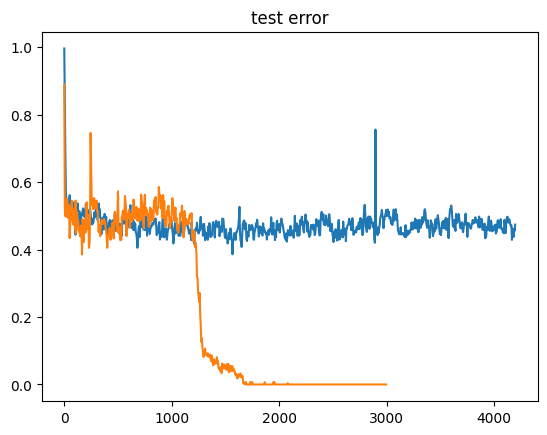

In [22]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,len(policy_test_acc.list)*5,5), 1.0-np.array(policy_test_acc.list))

a =pickle.load(open(f'sft+dpo_node20_sft_changeat_2_run.pkl', 'rb'))['policy_test_acc']
plt.plot(np.arange(0,len(a)*5,5), 1.0-np.array(a))
plt.title('test error')


(0.0, 0.5)

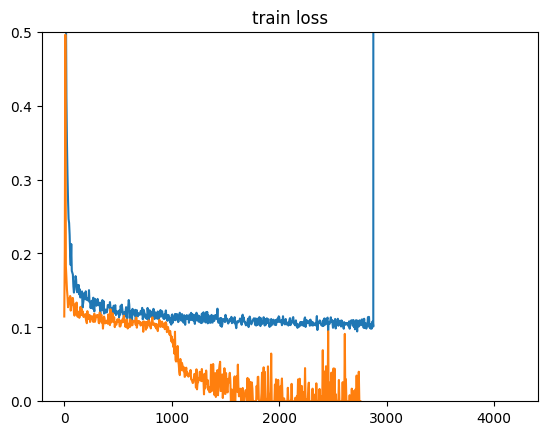

In [23]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,len(train_loss.list)*5,5), np.array(train_loss.list))

a =pickle.load(open(f'sft+dpo_node20_sft_changeat_2_run.pkl', 'rb'))['sft_loss']
plt.plot(np.arange(0,len(a)*5,5), np.array(a))
plt.title('train loss')
plt.ylim(0, 0.5)


In [24]:
# plt.plot(
#     pickle.load(open(f'sft+dpo_node20_sft_changeat_26_run.pkl', 'rb'))['train_loss'], label='NTP loss (SFT)')
# plt.plot(np.arange(60, 600),
#     np.array(pickle.load(open(f'sft+dpo_node20_sft_changeat_2_run.pkl', 'rb'))['sft_loss'][12:]), label='NTP loss (DPO with -ve)')
# plt.plot(
#     1.- np.array(pickle.load(open(f'sft+dpo_node20_sft_changeat_26_run.pkl', 'rb'))['policy_test_acc']), label='Test error (SFT)')
# plt.plot(np.arange(60, 600),
#     1. - np.array(pickle.load(open(f'sft+dpo_node20_sft_changeat_2_run.pkl', 'rb'))['policy_test_acc'][60:]), label='Test error (DPO with -ve)')

# plt.legend()



In [25]:
# import matplotlib.pyplot as plt
# plt.plot(
#     pickle.load(open(f'sft+dpo_node20_sft_changeat_26_run.pkl', 'rb'))['phard'], label='P(hard) SFT')

# plt.plot(np.arange(48, 600),
#     pickle.load(open(f'sft+dpo_node20_sft_changeat_2_run.pkl', 'rb'))['phard'][48:], label='P(hard) DPO with -ve')

# plt.legend()


In [26]:
# j = 31
# pos_input_tokens[j][j], pos_target_tokens[j][j], neg_input_tokens[j][j], neg_target_tokens[j][j]

In [27]:
# len(policy_test_acc.list)

In [28]:
# import matplotlib.pyplot as plt
# plt.plot(1.0- np.array(policy_test_acc.list))
# plt.plot(1.0- np.array(policy_train_acc.list))


In [29]:
# import matplotlib.pyplot as plt
# plt.plot(phard.list[:400])


In [30]:
# plt.plot(policy_train_acc.list)
# plt.plot(policy_test_acc.list)

In [31]:
# [round(1.0-x, 3) for x in np.array(pickle.load(open(f'sft_changeat_2_run.pkl', 'rb'))['policy_test_acc']).tolist()][:20]

In [32]:
# sft.list

In [33]:
import pickle
long_runs = {}
for point in [24, 36]:
    long_runs[point] = pickle.load(open(f'sft+dpo_node20_sft_changeat_{point}_run.pkl', 'rb'))

In [34]:
keys = list(long_runs[2].keys())
for point in long_runs:
    for k in keys:
        long_runs[point][k] = np.array(np.array(long_runs[point][k]).tolist())

In [35]:
with open('long_runs.pkl', 'wb') as f:
    pickle.dump(long_runs, f)